In [129]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


In [130]:
# Plot things
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')
    
def plot_functions(est, ax, df, d, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(d).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

In [131]:
# Import data

path = "romneysamples.csv"
df = pd.read_csv(path)
df.head()

,f,x,y
0,0.051199,0.01,0.015900
1,0.096800,0.11,0.058539
2,0.102637,0.12,0.072802
3,0.221640,0.27,0.224652
4,0.394863,0.42,0.370738


In [132]:
from sklearn.cross_validation import train_test_split

datasize=df.shape[0]
#split dataset using the index, as we have x, f, and y that we want to split.
itrain,itest = train_test_split(range(datasize),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

In [133]:
# split dataset into train and test

d = 10 # base polynomial degree

traintestlist = make_features(xtrain, xtest, [d])[0] # takes and returns lists
fit = lambda x: PolynomialFeatures(d).fit_transform(x.reshape(-1,1))
Xtrain, Xtest = fit(xtrain), fit(xtest)

In [134]:
# cross validation setup
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

ALPHA = [10**(-x) for x in xrange(9)] # which alphas to test

def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": ALPHA}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

bestmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)
bestmodel.best_estimator_, bestmodel.best_params_, bestmodel.best_score_, bestmodel.grid_scores_

(Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, solver='auto', tol=0.001),
 {'alpha': 0.01},
 -0.0033911761777304177,
 [mean: -0.01930, std: 0.01917, params: {'alpha': 1},
  mean: -0.00572, std: 0.00500, params: {'alpha': 0.1},
  mean: -0.00339, std: 0.00116, params: {'alpha': 0.01},
  mean: -0.00378, std: 0.00100, params: {'alpha': 0.001},
  mean: -0.00595, std: 0.00396, params: {'alpha': 0.0001},
  mean: -0.00811, std: 0.00706, params: {'alpha': 1e-05},
  mean: -0.03577, std: 0.04565, params: {'alpha': 1e-06},
  mean: -0.09942, std: 0.12911, params: {'alpha': 1e-07},
  mean: -0.57585, std: 0.98433, params: {'alpha': 1e-08}])

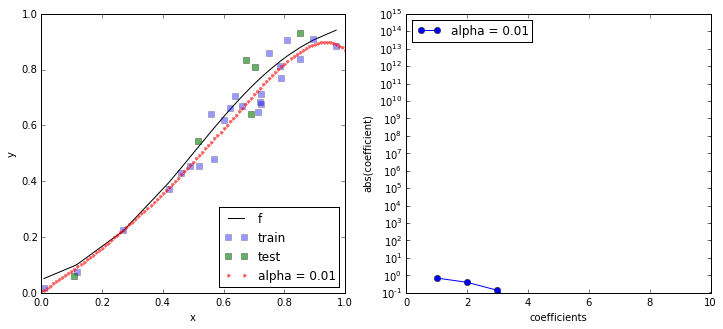

In [135]:
alphawechoose = bestmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r = rows
plot_functions(clf, l, df, d, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)